### import package

In [2]:
import os
import json
import pandas as pd
from tqdm import tqdm
from collect_data_webcrawl import *

root = '../../data'

os.makedirs(root, exist_ok=False)

## fast on same EC and same species
路徑: data/sequence_data
1. same genus: check if filename which ends with sp. contains same data in the other specific species file
2. pick out the rest sequence and search their species
3. combine fasta data with same EC and same species

In [ ]:

# from utils import *
# clean_dir(os.path.join(root, 'species_sequence_data'))

In [21]:
from Bio import SeqIO
import os
import re
import shutil
from utils import *

fasta_dir = os.path.join(root, 'uniprot/research/species/fasta')
output_dir = os.path.join(root, 'species_sequence_data/fasta')
os.makedirs(output_dir, exist_ok = True)

clean_dir(output_dir)

unk_specieses = [filename for filename in os.listdir(fasta_dir) if filename.endswith('.fasta') and re.search(r'\(organism_name:([^\|]+ sp.)\)', filename)]

k_specieses =  [filename for filename in os.listdir(fasta_dir) if filename.endswith('.fasta') and not re.search(r'\(organism_name:([^\|]+ sp.)\)', filename)]


for unk_species in unk_specieses:
    ec = re.search(r'ec:(\d+.\d+.\d+.\d+)', unk_species).group(1)
    genus = re.search(r'\(organism_name:([^\|]+) sp.\)', unk_species).group(1)
           

    species_files = [filename for filename in os.listdir(fasta_dir) 
                                            if filename.endswith('.fasta') 
                                            and genus in filename
                                            and not re.search(r'\(organism_name:([^\|] sp.)\)', filename)]

    fasta_file = os.path.join(fasta_dir,  unk_species)
    records = list(SeqIO.parse(fasta_file, 'fasta'))

    for record in records[:]:  # Iterate over a copy of the list
        id = re.search(r'\|([^\|]+)\|', record.id).group(1)

        for species_file in species_files:
            species_records = list(SeqIO.parse(os.path.join(fasta_dir, species_file), 'fasta'))
            
            found = [_ for _ in species_records if re.search(r'\|([^\|]+)\|', _.id).group(1) == id]
            
            if len(found)>0:
                records.remove(record)
                break
    if len(records)>0:
        output_match = re.search(r'\(ec:([^\|]+)\)AND\(organism_name:([^\|]+)\)_reviewed' ,k_species)
        output_name = (output_match.group(1) + '_' + output_match.group(2)).replace(' ','_').replace('.','_')
        output_path = os.path.join(output_dir, f'{output_name}_{len(records)}.fasta')
        with open(output_path, 'w') as f:
            SeqIO.write(records, f, 'fasta')
            


for k_species in k_specieses:
    src_file = os.path.join(fasta_dir, k_species)
    
    output_match = re.search(r'\(ec:([^\|]+)\)AND\(organism_name:([^\|]+)\)_reviewed' ,k_species)
    output_name = (output_match.group(1) + '_' + output_match.group(2)).replace(' ','_').replace('.','_')
    records = list(SeqIO.parse(src_file, 'fasta'))
    output_path = os.path.join(output_dir, f'{output_name}_{len(records)}.fasta')
    shutil.copy2(src_file, output_path)



Removed file: 3_2_1_1Aspergillus_terreus_13.fasta
Removed file: 3_2_1_1Rhizoctonia_solani_170.fasta
Removed file: 3_2_1_1Aspergillus_fumigatus_74.fasta
Removed file: 3_2_1_1Bacillus_licheniformis_19.fasta
Removed file: 3_2_1_1Paenibacillus_lactis_2.fasta
Removed file: 3_2_1_1Bacillus_cereus_76.fasta
Removed file: 3_2_1_1Pseudomonas_stutzeri_3.fasta
Removed file: 3_2_1_1Bacillus_subtilis_118.fasta
Removed file: 3_2_1_1Streptomyces_strain_449.fasta
Removed file: 3_2_1_1Penicillium_notatum_10.fasta
Removed file: 3_4_21_62Bacillus_licheniformis_3.fasta
Removed file: 3_2_1_78Lentinula_edodes_3.fasta
Removed file: 3_2_1_78Bacillus_subtilis_79.fasta
Removed file: 3_2_1_78Trichoderma_longibrachiatum_3.fasta
Removed file: 3_1_1_3Bacillus_subtilis_37.fasta
Removed file: 3_1_1_3Staphylococcus_arlettae_1.fasta
Removed file: 3_1_1_3Aspergillus_niger_23.fasta
Removed file: 3_1_1_3Trichosporon_asahii_5.fasta
Removed file: 3_1_1_3Candida_albicans_51.fasta
Removed file: 3_1_1_3Acinetobacter_calcoacetic

## MSA on same EC and same species

In [ ]:
# 直接做 data/species_sequence_data/fasta/中的MSA


# Collect ec number from Brenda
1. crawl all ec number from brenda
2. find data with `['Recommended Name']` containing any of ENZYME_TYPES
3. find reviewed data with `['Biotechnological use']` containing keywords `detergent`


In [ ]:
for enzyme_type in ENZYME_TYPES:
    directory_path = os.path.join(root,'brenda',enzyme_type,'reviewed') 
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)               
            df = pd.read_csv(file_path)
            if df.empty == False:
                df_detergent = df[df['Biotechnological use'].apply(lambda x: isinstance(x, str) and 'detergent' in x.lower())]
                end_index = filename.find('reviewed1') + len('reviewed1')
                if end_index != -1:                
                    save_file_name = f'{filename[:end_index].strip()}_{len(df_detergent)}_detergent.csv'
                save_path = os.path.join(root,'brenda',enzyme_type,'reviewed_detergent', save_file_name)
                df_detergent.to_csv(save_path, index=False)
                print(f'Save file to path: {save_path}')
            else:
                print(f'No data found in {filename}')


# Collect data from UniProt
1. crawl by using query in url from UniProt
2. find reviewed data with `['Biotechnological use']` containing keywords `detergent`


In [ ]:
directory_path = os.path.join(root,'uniprot','reviewed') 
for filename in tqdm(os.listdir(directory_path)):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)               
        df = pd.read_csv(file_path)

        df_detergent = df[df['Biotechnological use'].apply(lambda x: isinstance(x, str) and 'detergent' in x.lower())]
        end_index = filename.find('reviewed1') + len('reviewed1')
        if end_index != -1:                
            save_file_name = f'{filename[:end_index].strip()}_{len(df_detergent)}_detergent.csv'
        save_path = os.path.join(root,'uniprot','reviewed_detergent', save_file_name)

        df_detergent.to_csv(save_path, index=False)

        print(f'Save file to path: {save_path}')


# `detergent` as query to UniProt
1. use `detergent` as query in url to crawl data from UniProt
2. remove data containing `detergent-resistent`
3. analyze which ec number contains largest amount of datas

In [ ]:
crawl_uniprot_by_query('detergent',save_path = 'data/uniprot/reviewed_detergent/', fields = '',return_format = 'json',reviewed='false')

In [ ]:
crawl_uniprot_by_query('detergent',save_path = 'data/uniprot/reviewed_detergent/', fields = '',return_format = 'json')


In [ ]:


json_file = 'detergent_reviewed1_450.json'
json_path = os.path.join(root,'uniprot/reviewed_detergent', json_file)

detergent_enzymes = []

with open(json_path, 'r') as f:
    datas = json.load(f)

for data in datas:
    data_str = str(data).lower()
    if 'detergent' in data_str and 'detergent-resistant' not in data_str:
        detergent_enzymes.append(data)

    # break


save_path = f'{root}/uniprot/reviewed_detergent_ec#/detergent-enzymes_reviewed1_{len(detergent_enzymes)}.json'
with open(save_path, 'w', encoding='utf-8') as json_file:
    json.dump(detergent_enzymes, json_file, ensure_ascii=False, indent=4)


print(f'Save file to path: {save_path}')




# Collating datas for target EC numbers 

|Category|EC Number|Protein Name|Reivewed|Unreviewed|
|---|---|---|---|---|
|Amylase|3.2.1.1|$\alpha$-amylase|137|31069|
|Cellulase|3.2.1.4|carboxymethyl cellulase (CMCase,endo-β-1,4-glucanase)|302|48445|
|Lipase|3.1.1.3|triacylglycerol lipase|202|12762|
|Mannanase|3.2.1.78|β-mannanase|61|8541|
|Pectinase|4.2.2.2|Pectate Lyase|113|15406|
|Pectinase|3.2.1.15|Polygalacturonase (PG)|89|5794|
|Protease|3.4.21.14|Microbial serine proteases|0|5|


## Filtering data using EC number and organism

|EC Number|Protein Name|Organism|#Reviewed|#Unreviewed|
|---|---|---|---|---|
|3.1.1.3|triacylglcerol acylhydrolases|Acinetobacter sp.|0|22|
|3.1.1.3|triacylglcerol acylhydrolases|Bacillus subtilis strain|2|8|
|3.1.1.3|triacylglycrol acylhydrolases|Candida albicans (C. albicans)|11|48|
|3.2.1.1|α-amylase|Bacillus licheniformis AS08E|0|1|
|3.2.1.1|α-amylase|Streptomyces strain A3|0|2|
|3.2.1.4|CMCase|Bacillus sp.KSM-522|1|0|
|3.2.1.4|CMCase|Bacillus sp.KSM-635|1|0|
|3.2.1.4|CMCase|Fibrobacter succinogenes S85|1|19|



In [ ]:
directory = os.path.join(root,'uniprot','research','detergent_enzymes_from_paper')
pro_bar = tqdm(os.listdir(directory))

for filename in pro_bar:
    file = os.path.join(directory,filename)
    df = pd.read_excel(file)
    for index, row in df.iterrows():   
        pro_bar.set_postfix(processing = f'(ec:{row['EC Number']})AND(organism_name:{row['Source Organism']})')
        if row['EC Number']!='' and row['Source Organism'] != '':
            data = crawl_uniprot_by_query(query=f'(ec:{row['EC Number']})AND(organism_name:{row['Source Organism']})',save_path='data/uniprot/research/fasta/', 
                                        fields=['ec','accession', 'id', 'protein_name','organism_name','ph_dependence', 'temp_dependence', 'ft_motif','ft_act_site', 'ft_binding', 'ft_dna_bind', 'kinetics', 'cc_cofactor','cc_activity_regulation','cc_catalytic_activity','cc_function', 'cc_biotechnology'],
                                        headers=['EC number', 'Entry', 'Entry Name','Protein names','Organism', 'pH dependence', 'Temperature dependence', 'Motif', 'Active site', 'Binding site', 'DNA binding', 'Kinetics', 'Cofactor', 'Activty regulation', 'Catalytic activity', 'Function [CC]', 'Biotechnological use'])

            if len(data)>0:
                download_fasta(query=f'(ec:{row['EC Number']})AND(organism_name:{row['Source Organism']})',save_path='data/uniprot/research/fasta/')


## Statistics of all original .fasta file

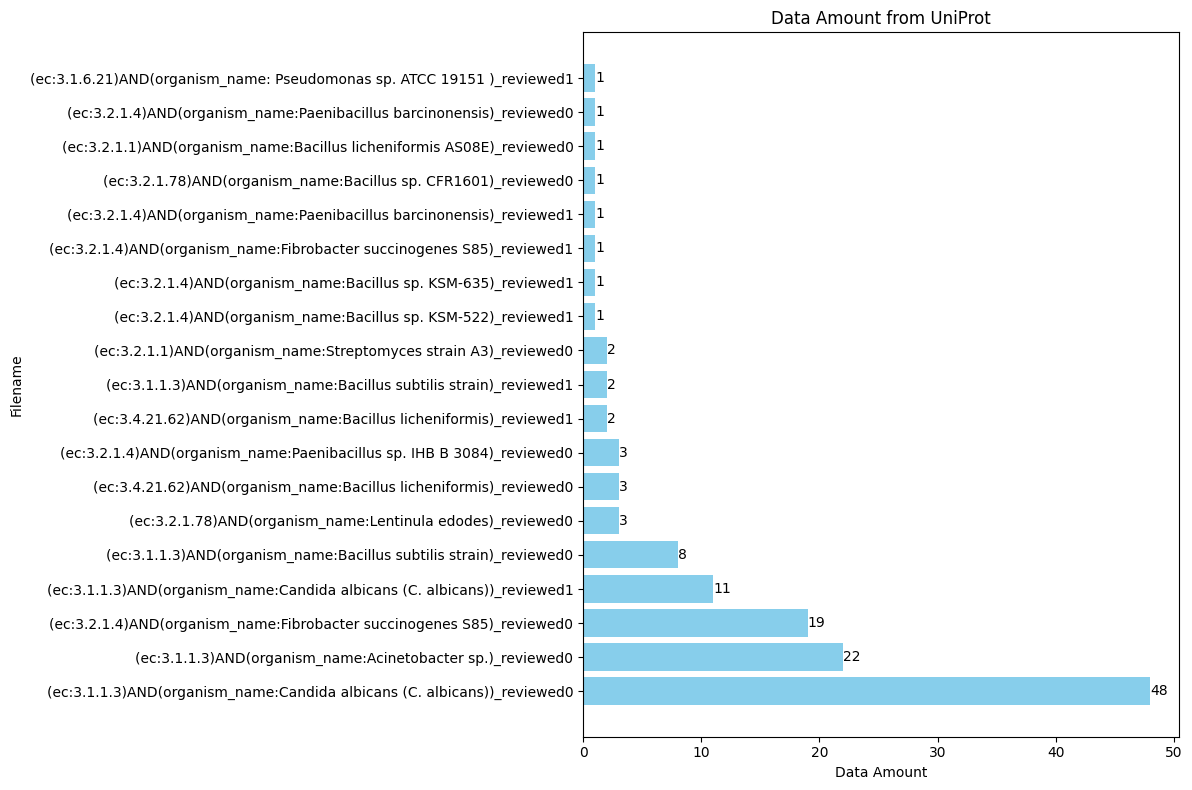

In [3]:
import os
import re
import matplotlib.pyplot as plt

directory = os.path.join(root, 'uniprot', 'research', 'fasta')
all_files = [file for file in os.listdir(directory) if file.endswith('.fasta')]

# List to store the data
data_counts = []

# Loop through the files in the directory
for filename in all_files:
    
    match = re.search(r'_([0-9]+)\.fasta$', filename)    
    data_amount = int(match.group(1))

    pattern = r'(\(ec:\d+\.\d+\.\d+\.\d+\)AND\(organism_name:.*\)_reviewed\d+)_\d+\.fasta$'
    name_match = re.search(pattern, filename)
    filename = name_match.group(1)   

    
    data_counts.append((filename, data_amount))

# Sort data counts by data amount in descending order
data_counts.sort(key=lambda x: x[1], reverse=True)

# Separate filenames and data amounts for plotting
filenames, data_amounts = zip(*data_counts)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(filenames, data_amounts, color='skyblue')
plt.xlabel('Data Amount')
plt.ylabel('Filename')
plt.title('Data Amount from UniProt')
plt.tight_layout()

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center')

# Save the plot as an image file
plt.savefig('data/uniprot/research/fasta/data_amounts_bar_chart.png', dpi=300, bbox_inches='tight')

## Combine data with same EC Number

In [22]:
import os
import re
import pandas as pd

directory = os.path.join(root, 'uniprot/research/')
all_files = [file for file in os.listdir(os.path.join(directory, 'fasta')) if file.endswith('.fasta')]

# store ec contents
ec_content = {}
df_content = {}

for filename in all_files:
    # regular expression to get ec number
    match = re.search(r'\(ec:(\d+\.\d+\.\d+\.\d+)\)', filename)
    if match:
        ec_number = match.group(1)
        
        # read csv file
        csv_filename = f'{filename[:-6]}.csv'
        csv_path = os.path.join(directory, 'fasta', csv_filename)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
        else:
            print(f"CSV file not found: {csv_path}")
            continue
        
        # read fasta file
        with open(os.path.join(directory, 'fasta', filename), 'r') as file:
            content = [line for line in file if line.strip()]
        
        if ec_number in ec_content:
            ec_content[ec_number].extend(content)
            df_content[ec_number] = pd.concat([df_content[ec_number], df], ignore_index=True)
        else:
            ec_content[ec_number] = content
            df_content[ec_number] = df

# create new file for each EC number
output_directory = os.path.join(directory, 'motif/ec_num')
os.makedirs(output_directory, exist_ok=True)

# 創建一個函數來讀取 FASTA 文件並刪除重複序列
def remove_duplicate_sequences(fasta_content):
    sequences = {}
    unique_content = []
    for line in fasta_content:
        if line.startswith('>'):
            header = line
            sequences[header] = ""
        else:
            sequences[header] += line.strip()
    
    for header, sequence in sequences.items():
        if sequence not in unique_content:
            unique_content.append(header)
            unique_content.append(sequence + '\n')
    
    return unique_content

# 在寫入 FASTA 文件之前，先刪除重複序列
for ec_number, content in ec_content.items():
    fasta_filename = f"ec_{ec_number}.fasta"
    csv_filename = f"ec_{ec_number}.csv"
    
    # 刪除重複序列
    unique_content = remove_duplicate_sequences(content)
    
    with open(os.path.join(output_directory, fasta_filename), 'w') as file:
        file.writelines(unique_content)
    
    if ec_number in df_content:
        # Remove duplicate rows in DataFrame
        df_unique = df_content[ec_number].drop_duplicates()
        df_unique.to_csv(os.path.join(output_directory, csv_filename), index=False)
    else:
        print(f"No DataFrame content for EC number: {ec_number}")

## Statistics of combined fasta file

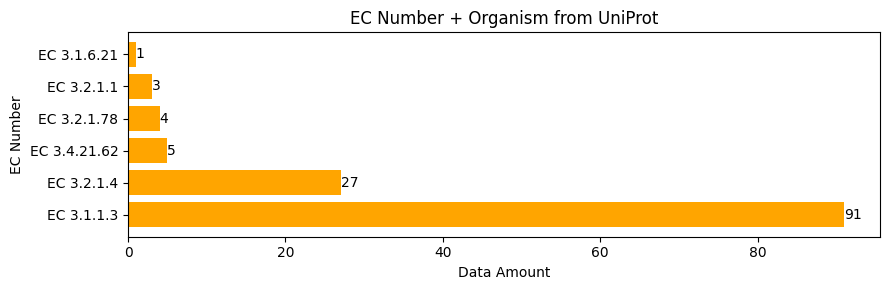

In [48]:
from Bio import SeqIO
import os
import re
import matplotlib.pyplot as plt



directory = os.path.join(root, 'uniprot/research')
data_counts = []

for filename in os.listdir(os.path.join(directory, 'motif/ec_num')):
    if filename.endswith('.fasta'):
        input_file = os.path.join(directory, 'motif/ec_num', filename)
        records = list(SeqIO.parse(input_file, 'fasta'))
    
        data_amount = len(records)

        ec_pattern = r'(\d+\.\d+\.\d+\.\d+)'
        ec_match = str(re.search(ec_pattern, filename).group(1))
        ec_number = 'EC ' + ec_match

        data_counts.append((ec_number, data_amount))

# Sort data counts by data amount in descending order
data_counts.sort(key=lambda x: x[1], reverse=True)

# Separate filenames and data amounts for plotting
ec_numbers, data_amounts = zip(*data_counts)

# Plotting
plt.figure(figsize=(9,3))
bars = plt.barh(ec_numbers, data_amounts, color='orange')
plt.xlabel('Data Amount')
plt.ylabel('EC Number')
plt.title('EC Number + Organism from UniProt')
plt.tight_layout()

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center')

# Save the plot as an image file
plt.savefig('data/uniprot/research/motif/ec_num/data_amounts_bar_chart.png', dpi=300, bbox_inches='tight')


## Cluster, find representative sequence: EC + organism

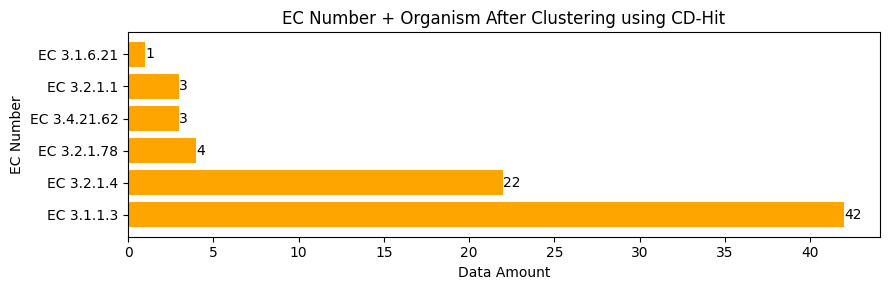

In [49]:
import os
from Bio import SeqIO
import subprocess
import re


output_dir = os.path.join(root, 'ec_organism')
fasta_dir = os.path.join(root, 'uniprot/research/motif/ec_num')
all_files = [file for file in os.listdir(fasta_dir) if file.endswith('.fasta')]

threshold = 0.9

data_counts = []

for filename in all_files:
    input_file = os.path.join(fasta_dir, filename)
    cluster_path = os.path.join(output_dir, f'cluster/{filename[:-6]}')
    cluster_file = f'output{int(threshold*100)}'


    os.makedirs(cluster_path, exist_ok=True)
    
    # subprocess.run(['cdhit', f'-i {input_file}', f'-o output', f'-c {threshold}', '-sc 0', '-g 1'])
    subprocess.run(['cdhit', '-i', input_file, '-o', os.path.join(cluster_path,cluster_file), '-c', f'{threshold}', '-sc', '0', '-g', '1'], capture_output=True)


    records = list(SeqIO.parse(os.path.join(cluster_path,cluster_file), 'fasta'))

    ec_num = re.search(r'(\d+\.\d+\.\d+\.\d+)', filename).group(1)
    data_counts.append((f'EC {ec_num}', len(records)))

    for record in records:
        
        id = re.search(r'\|([^\|]+)\|', str(record.id)).group(1)
        output_file = os.path.join(output_dir,f'scaffolding-pdbs/{id}.fasta')

        with open(output_file, 'w') as f:
            SeqIO.write(record, f, 'fasta')


# Sort data counts by data amount in descending order
data_counts.sort(key=lambda x: x[1], reverse=True)

# Separate filenames and data amounts for plotting
ec_numbers, data_amounts = zip(*data_counts)

# Plotting
plt.figure(figsize=(9,3))
bars = plt.barh(ec_numbers, data_amounts, color='orange')
plt.xlabel('Data Amount')
plt.ylabel('EC Number')
plt.title('EC Number + Organism After Clustering using CD-Hit')
plt.tight_layout()

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center')

# Save the plot as an image file
plt.savefig(os.path.join(output_dir,'cluster/data_amounts_bar_chart.png'), dpi=300, bbox_inches='tight')



## Comparison before and after clustering: EC + organism

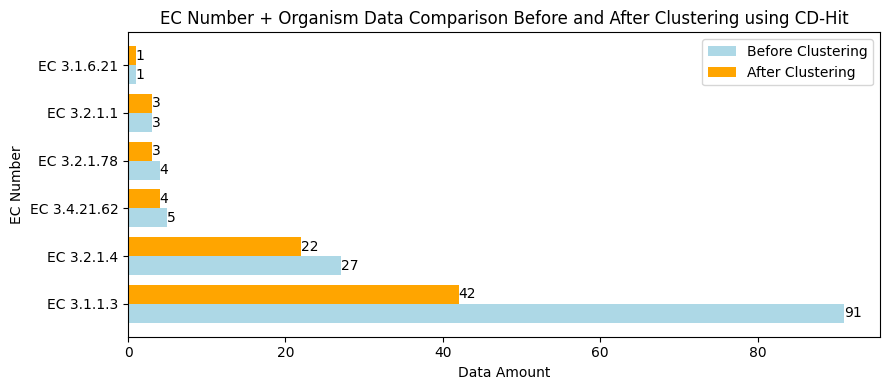

In [6]:
from Bio import SeqIO
import os
import re
import matplotlib.pyplot as plt


dir_before = os.path.join(root, 'uniprot/research/motif/ec_num')
dir_after = os.path.join(root, 'ec_organism/cluster')

data_before = []
data_after = []
all_files = [file for file in os.listdir(dir_before) if file.endswith('.fasta')]
threshold = 90

for filename in all_files:
    # Before clustering
    input_file = os.path.join(dir_before, filename)
    records = list(SeqIO.parse(input_file, 'fasta'))
    ec_num = f'EC {re.search(r"(\d+\.\d+\.\d+\.\d+)", filename).group(1)}'
    data_before.append((ec_num, len(records)))

    # After clustering
    input_file = os.path.join(dir_after, f"{filename[:-6]}/output{threshold}")
    records = list(SeqIO.parse(input_file, 'fasta'))
    data_after.append((ec_num, len(records)))

# Sort data counts by data amount in descending order
data_before.sort(key=lambda x: x[1], reverse=True)
data_after.sort(key=lambda x: x[1], reverse=True)

# Create the combined bar plot
fig, ax = plt.subplots(figsize=(9, 4))
bar_width = 0.4
x = [i for i in range(len(data_before))]

# Plot the bars
ax.barh([i - bar_width/2 for i in x], [count for _, count in data_before], bar_width, label="Before Clustering", color="lightblue")
ax.barh([i + bar_width/2 for i in x], [count for _, count in data_after], bar_width, label="After Clustering", color="orange")

# Add labels and title
ax.set_xlabel("Data Amount")
ax.set_ylabel("EC Number")
ax.set_title("EC Number + Organism Data Comparison Before and After Clustering using CD-Hit")
ax.set_yticks(x)
ax.set_yticklabels([ec_num for ec_num, _ in data_before])
ax.legend()

# Add value labels to each bar
for bars, data in zip([ax.containers[0], ax.containers[1]], [data_before, data_after]):
    for bar, (_, count) in zip(bars, data):
        ax.text(count, bar.get_y() + bar.get_height()/2, str(count), ha="left", va="center")

fig.tight_layout()
plt.savefig(os.path.join(root, 'ec_organism/data_amounts_bar_chart.png'), dpi=300, bbox_inches='tight')

## Clean directory

In [8]:
import os
import time
import shutil


def clean_directory(directory_path, days_threshold = 30, threshold = False):
    current_time = time.time()
    
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        def clean(item, path):        
            if os.path.isfile(path):
                os.remove(item_path)
                print(f"Removed file: {item}")
            elif os.path.isdir(path):
                shutil.rmtree(path)
                print(f"Removed directory: {item}")
        
        creation_time = os.path.getctime(item_path)
        if threshold == True:
            if (current_time - creation_time) // (24 * 3600) >= days_threshold:
                clean(item, item_path)
        else:
            clean(item, item_path)
            

# Example usage
# directory_to_clean = os.path.join('')
# days_to_keep = 30

# clean_directory(directory_to_clean, days_to_keep)


In [21]:
# clean_directory(os.path.join(root, 'uniprot/research/motif/interproscan'))

Removed file: log.txt


## Get motif by using InterProScan

In [ ]:
import subprocess
import os
import shutil
from Bio import AlignIO, SeqIO
from collect_data_webcrawl import *
import numpy as np
import re
from tqdm import tqdm

clean_directory(os.path.join(root, 'uniprot/research/motif/interproscan'))

directory = os.path.join(root, 'uniprot/research/')
all_files = [file for file in os.listdir(os.path.join(directory,'motif/ec_num')) if file.endswith('.fasta')]
path_to_interproscan = '/home/chialun/tools/interproscan/interproscan-5.69-101.0/./interproscan.sh'



for filename in all_files:

    # if os.path.exists(os.path.join(directory, f'motif/all_data/{filename[:-6]}_details.csv')):
    #     continue  

    input_file = os.path.join(directory,'motif/ec_num', filename)
    
    interproscan_file = os.path.join(directory,f'motif/interproscan/{filename[:-6]}_motif')        
    
    subprocess.run([path_to_interproscan, '-i', input_file, '-b', interproscan_file, '-f tsv', '-appl Pfam', '-dp'],
                    stdout=open(os.path.join(directory, 'motif/interproscan/log.txt'), 'w'))
    
    motif_df = pd.read_csv(os.path.join(directory,f'motif/interproscan/{filename[:-6]}_motif.tsv'), header=None, sep='\t')

    info_filename = f'{filename[:-6]}.csv'
    info_df = pd.read_csv(os.path.join(directory, 'motif/ec_num', info_filename))

    records = list(SeqIO.parse(input_file, 'fasta'))

    ec_match = re.search(r"ec_(\d+\.\d+\.\d+\.\d+)", filename)
    ec_num = ec_match.group(1)

    data = {
        'EC': [],
        'Entry': [],
        'Protein': [],
        'Organism': [],
        'Motif_start': [],
        'Motif_end': [],
        'pH_left': [],
        'pH_right': [],
        'Temperature_left': [],
        'Temperature_right': [],
        'Sequence': []
    }
    

    p_bar = tqdm(info_df.iterrows(), total=info_df.shape[0], desc=f'Processing {filename[:-6]}')
    for _, row in p_bar:

        # information
        data['EC'].append(ec_num)
        data['Entry'].append(row['Entry'])
        data['Protein'].append(row['Protein names'])
        data['Organism'].append(row['Organism'])
        
        # motif
        motif_options = motif_df[motif_df.iloc[:, 0].str.contains(row['Entry'], na=False)].iloc[:, 5:9]
        if len(motif_options) > 0:
            target_motif = motif_options.loc[motif_options.iloc[:, 3].idxmin()]
            data['Motif_start'].append(target_motif.iloc[1])
            data['Motif_end'].append(target_motif.iloc[2])
        else:
            data['Motif_start'].append('')
            data['Motif_end'].append('')

        # temperature, pH value
        organism = row['Organism']   
        pattern = r'(\d+) - (\d+)'
        # temperature
        temperatures = crawl_brenda_table_by_ec(ec_num = ec_num, organism = organism, table='temperature')
        temp_opt = temperatures['Temperature_Optimum'] if 'Temperature_Optimum' in temperatures else ''    
        temp_match = re.search(pattern, temp_opt)    
        if temp_match:
            temp_left = temp_match.group(1)
            temp_right = temp_match.group(2)
            data['Temperature_left'].append(temp_left)
            data['Temperature_right'].append(temp_right)
        else:
            data['Temperature_left'].append(temp_opt)
            data['Temperature_right'].append('')        
        # pH
        pHs = crawl_brenda_table_by_ec(ec_num = ec_num, organism = organism, table='pH')
        pH_opt = pHs['pH_Optimum'] if 'pH_Optimum' in pHs else ''
        pH_match = re.search(pattern, pH_opt) 
        if pH_match:
            pH_left = pH_match.group(1)
            pH_right = pH_match.group(2)
            data['pH_left'].append(pH_left)
            data['pH_right'].append(pH_right)
        else:
            data['pH_left'].append(pH_opt)
            data['pH_right'].append('')
            
        p_bar.set_postfix(entry=row['Entry'], organism=organism, pH_opt = pH_opt, temp_opt = temp_opt)

        # sequence
        sequenc=''
        for record in records:
            match = re.search(r'\|([^\|]+)\|', str(record.id))
            if match and match.group(1) == row['Entry']:
                sequence = str(record.seq)
                break
        data['Sequence'].append(sequence)

    train_df = pd.DataFrame(data)

    output_filename = f'{filename[:-6]}_details.csv'
    train_df.to_csv(os.path.join(directory, 'motif/all_data', output_filename), index=False)   

print(f'Finished collating detailed information for all sequences in {os.path.join(directory, 'motif/all_data')}')


## Collating motif dictionary for `ec_organism/scaffolding-pdbs`

In [ ]:
# clean_directory(os.path.join(root, 'ec_organism/scaffolding-msas'))

## Collating msas data fro `ec_organism/scaffolding-msas`

## Collating different EC and species

In [9]:
import os
import re
import pandas as pd
from openpyxl import load_workbook

directory = os.path.join(root, 'uniprot/research/')
enzyme_path = os.path.join(directory, 'detergent_enzymes_from_paper/detergents.xlsx')
enzymes_file = pd.ExcelFile(enzyme_path)
enzymes_sheets = pd.read_excel(enzymes_file, sheet_name=None)

datas = {}
for sheet_name, df in enzymes_sheets.items():
    
    if sheet_name.lower() not in ENZYME_TYPES:
        continue
    for ec, organism in zip(df['EC Number'], df['Source Organism']):

        ec = ec if ec is not None else 'None'
        match = re.match(r'^(\S+\s+\S+)', organism)
        species = match.group(1) if match else organism

            
        if ec not in datas:
            datas[ec] = {
                'EC': [],
                'Species': [],
                'Organism': []
            }
        datas[ec]['EC'].append(ec)
        datas[ec]['Species'].append(species)
        datas[ec]['Organism'].append(organism)



output_path = os.path.join(directory, 'species/species.xlsx')

# make sure path exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # 寫入數據
    for ec in datas:
        df = pd.DataFrame(datas[ec])
        df.to_excel(writer, sheet_name=str(ec), index=False)


print(f'Finished writing EC Number and species in path {output_path}')



Finished writing EC Number and species in path ../../data/uniprot/research/species/species.xlsx


## Statistics of species

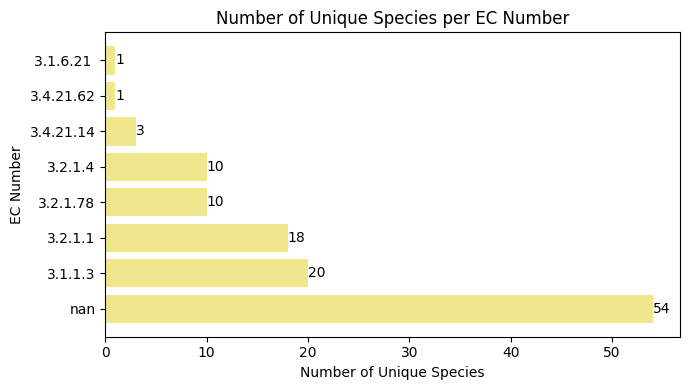

<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# read in excel file
directory = os.path.join(root, 'uniprot/research/')
excel_file = os.path.join(directory, 'species/species.xlsx')
xls = pd.ExcelFile(excel_file)

# 儲存每個工作表的物種數量
species_counts = {}

# 遍歷每個工作表
for sheet_name in xls.sheet_names:
    # 讀取工作表
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # 統計不同物種的數量
    unique_species_count = df['Species'].nunique()
    
    # 儲存結果
    species_counts[sheet_name] = unique_species_count

# 排序結果（可選）
species_counts = dict(sorted(species_counts.items(), key=lambda item: item[1], reverse=True))

# 繪製橫向長條圖
fig, ax = plt.subplots(figsize=(7,4))
bars = ax.barh(list(species_counts.keys()), list(species_counts.values()), color='khaki')

# 設置標題和軸標籤
ax.set_title('Number of Unique Species per EC Number')
ax.set_xlabel('Number of Unique Species')
ax.set_ylabel('EC Number')

# 在長條末端添加數字
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
            ha='left', va='center')# , fontweight='bold'

# 調整佈局
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(directory, 'species/data_amounts_bar_chart.png'), dpi=300, bbox_inches='tight')


## EC Number + Species from UniProt

In [ ]:
import os
import pandas as pd
from collect_data_webcrawl import *

root = '../../data'

directory = os.path.join(root, 'uniprot/research/')
species_path = os.path.join(directory, 'species/species.xlsx')
species_file = pd.ExcelFile(species_path)
species_sheets = pd.read_excel(species_file, sheet_name=None)


for sheet_name, df in species_sheets.items():
    if sheet_name == 'nan':
        continue
    pro_bar = tqdm(df.iterrows(), total=len(df))
    for index, row in pro_bar:   
        query = f'(ec:{row['EC']})AND(organism_name:{row['Species']})'
        pro_bar.set_postfix(processing = query)
        
        ''' unreviewed '''
        data = crawl_uniprot_by_query(query=query,save_path=os.path.join(root, 'uniprot/research/species/fasta'), reviewed='false',
                                    fields=['ec','accession', 'id', 'protein_name','organism_name','ph_dependence', 'temp_dependence', 'ft_motif','ft_act_site', 'ft_binding', 'ft_dna_bind', 'kinetics', 'cc_cofactor','cc_activity_regulation','cc_catalytic_activity','cc_function', 'cc_biotechnology'],
                                    headers=['EC number', 'Entry', 'Entry Name','Protein names','Organism', 'pH dependence', 'Temperature dependence', 'Motif', 'Active site', 'Binding site', 'DNA binding', 'Kinetics', 'Cofactor', 'Activty regulation', 'Catalytic activity', 'Function [CC]', 'Biotechnological use'])
        if len(data)>0:
            download_fasta(query=query,save_path=os.path.join(root, 'uniprot/research/species/fasta'),reviewed='false')


        ''' reviewed '''
        data = crawl_uniprot_by_query(query=query,save_path=os.path.join(root, 'uniprot/research/species/fasta'),
                                    fields=['ec','accession', 'id', 'protein_name','organism_name','ph_dependence', 'temp_dependence', 'ft_motif','ft_act_site', 'ft_binding', 'ft_dna_bind', 'kinetics', 'cc_cofactor','cc_activity_regulation','cc_catalytic_activity','cc_function', 'cc_biotechnology'],
                                    headers=['EC number', 'Entry', 'Entry Name','Protein names','Organism', 'pH dependence', 'Temperature dependence', 'Motif', 'Active site', 'Binding site', 'DNA binding', 'Kinetics', 'Cofactor', 'Activty regulation', 'Catalytic activity', 'Function [CC]', 'Biotechnological use'])
        if len(data)>0:
            download_fasta(query=query,save_path=os.path.join(root, 'uniprot/research/species/fasta'))



        


## Combine data species data with same EC number

In [13]:
import os
import re
import pandas as pd

directory = os.path.join(root, 'uniprot/research/')
all_files = [file for file in os.listdir(os.path.join(directory, 'species/fasta')) if file.endswith('.fasta')]

# store ec contents
ec_content = {}
df_content = {}

for filename in all_files:
    # regular expression to get ec number
    match = re.search(r'\(ec:(\d+\.\d+\.\d+\.\d+)\)', filename)
    if match:
        ec_number = match.group(1)
        
        # read csv file
        csv_filename = f'{filename[:-6]}.csv'
        csv_path = os.path.join(directory, 'species/fasta', csv_filename)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
        else:
            print(f"CSV file not found: {csv_path}")
            continue
        
        # read fasta file
        with open(os.path.join(directory, 'species/fasta', filename), 'r') as file:
            content = [line for line in file if line.strip()]
        
        if ec_number in ec_content:
            ec_content[ec_number].extend(content)
            df_content[ec_number] = pd.concat([df_content[ec_number], df], ignore_index=True)
        else:
            ec_content[ec_number] = content
            df_content[ec_number] = df

# create new file for each EC number
output_directory = os.path.join(directory, 'species/motif/ec_num')
os.makedirs(output_directory, exist_ok=True)

def remove_duplicate_sequences(fasta_content):
    sequences = {}
    unique_content = []
    for line in fasta_content:
        if line.startswith('>'):
            header = line
            sequences[header] = ""
        else:
            sequences[header] += line.strip()
    
    for header, sequence in sequences.items():
        if sequence not in unique_content:
            unique_content.append(header)
            unique_content.append(sequence + '\n')
    
    return unique_content

# 在寫入 FASTA 文件之前，先刪除重複序列
for ec_number, content in ec_content.items():
    fasta_filename = f"ec_{ec_number}.fasta"
    csv_filename = f"ec_{ec_number}.csv"
    
    # 刪除重複序列
    unique_content = remove_duplicate_sequences(content)
    
    with open(os.path.join(output_directory, fasta_filename), 'w') as file:
        file.writelines(unique_content)
    
    if ec_number in df_content:
        # Remove duplicate rows in DataFrame
        df_unique = df_content[ec_number].drop_duplicates()
        df_unique.to_csv(os.path.join(output_directory, csv_filename), index=False)
    else:
        print(f"No DataFrame content for EC number: {ec_number}")

## Check if there's duplicate in sp. versus other specific species

In [14]:
from Bio import SeqIO
import os
import re
import shutil
from utils import *

fasta_dir = os.path.join(root, 'uniprot/research/species/fasta')
output_dir = os.path.join(root, 'species_sequence_data/fasta')
os.makedirs(output_dir, exist_ok = True)

clean_dir(output_dir)

unk_specieses = [filename for filename in os.listdir(fasta_dir) if filename.endswith('.fasta') and re.search(r'\(organism_name:([^\|]+ sp.)\)', filename)]

k_specieses =  [filename for filename in os.listdir(fasta_dir) if filename.endswith('.fasta') and not re.search(r'\(organism_name:([^\|]+ sp.)\)', filename)]


for unk_species in unk_specieses:
    ec = re.search(r'ec:(\d+.\d+.\d+.\d+)', unk_species).group(1)
    genus = re.search(r'\(organism_name:([^\|]+) sp.\)', unk_species).group(1)
           

    species_files = [filename for filename in os.listdir(fasta_dir) 
                                            if filename.endswith('.fasta') 
                                            and genus in filename
                                            and not re.search(r'\(organism_name:([^\|] sp.)\)', filename)]

    fasta_file = os.path.join(fasta_dir,  unk_species)
    records = list(SeqIO.parse(fasta_file, 'fasta'))

    for record in records[:]:  # Iterate over a copy of the list
        id = re.search(r'\|([^\|]+)\|', record.id).group(1)

        for species_file in species_files:
            species_records = list(SeqIO.parse(os.path.join(fasta_dir, species_file), 'fasta'))
            
            found = [_ for _ in species_records if re.search(r'\|([^\|]+)\|', _.id).group(1) == id]
            
            if len(found)>0:
                records.remove(record)
                break
    if len(records)>0:
        output_match = re.search(r'\(ec:([^\|]+)\)AND\(organism_name:([^\|]+)\)_reviewed' ,k_species)
        output_name = (output_match.group(1) + '_' + output_match.group(2)).replace(' ','_').replace('.','_')
        output_path = os.path.join(output_dir, f'{output_name}_{len(records)}.fasta')
        with open(output_path, 'w') as f:
            SeqIO.write(records, f, 'fasta')
            


for k_species in k_specieses:
    src_file = os.path.join(fasta_dir, k_species)
    
    output_match = re.search(r'\(ec:([^\|]+)\)AND\(organism_name:([^\|]+)\)_reviewed' ,k_species)
    output_name = (output_match.group(1) + '_' + output_match.group(2)).replace(' ','_').replace('.','_')
    records = list(SeqIO.parse(src_file, 'fasta'))
    output_path = os.path.join(output_dir, f'{output_name}_{len(records)}.fasta')
    shutil.copy2(src_file, output_path)

## Statistics of combined EC number + species: fasta file

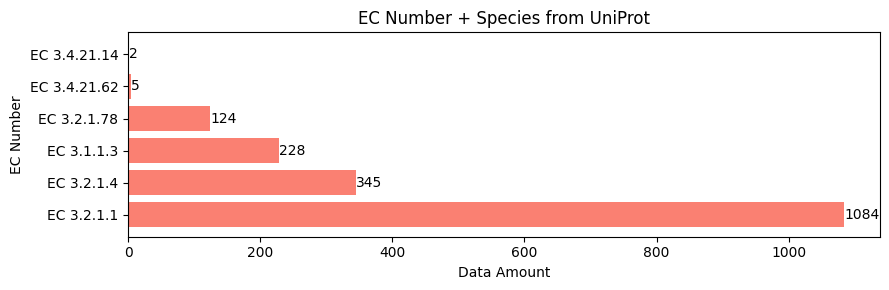

In [16]:
from Bio import SeqIO
import os
import re
import matplotlib.pyplot as plt



directory = os.path.join(root, 'uniprot/research')
data_counts = []

for filename in os.listdir(os.path.join(directory, 'species/motif/ec_num')):
    if filename.endswith('.fasta'):
        input_file = os.path.join(directory, 'species/motif/ec_num', filename)
        records = list(SeqIO.parse(input_file, 'fasta'))
    
        data_amount = len(records)

        ec_pattern = r'(\d+\.\d+\.\d+\.\d+)'
        ec_match = str(re.search(ec_pattern, filename).group(1))
        ec_number = 'EC ' + ec_match

        data_counts.append((ec_number, data_amount))

# Sort data counts by data amount in descending order
data_counts.sort(key=lambda x: x[1], reverse=True)

# Separate filenames and data amounts for plotting
ec_numbers, data_amounts = zip(*data_counts)

# Plotting
plt.figure(figsize=(9,3))
bars = plt.barh(ec_numbers, data_amounts, color='salmon')
plt.xlabel('Data Amount')
plt.ylabel('EC Number')
plt.title('EC Number + Species from UniProt')
plt.tight_layout()

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             ha='left', va='center')

# Save the plot as an image file
plt.savefig(os.path.join(directory, 'species/motif/ec_num/data_amounts_bar_chart.png'), dpi=300, bbox_inches='tight')


## Cluster, find representative sequence: EC + Species

## InterProScan of EC Number + species

```
projects
└──EvoDiff
    └──data  
        ├── brenda       
        └── uniprot  
            └── research
                ├── detergent_enzymes_from_paper
                ├── fasta
                ├── msa    
                ├── motif  
                    ├── all_info
                    ├── ec_num
                    ├── interproscan
                    ├── original
                    └── msa                       
                └── species
                    ├── fasta
                    ├── msa
                    └── motif  
                        ├── all_info
                        ├── ec_num
                        ├── interproscan
                        ├── original
                        └── msa    
    ├── src
        ├── conditional_generation.py
        ├── main.py
        ├── rmsd_analysis.py
        ├── percent_similarity_msa.py
        └── utils.py    
    ├── collect_data_webcrawl.py
    ├── collate_data.ipynb
    └── evodiff.ipynb
├──TemStaPro
    ├── models
    ├── makefile
    └── tempstapro
├──EpHod
    ├── ephod
        ├── saved_models
            ├── AAC-SVR
            └── RLAT
        ├── predict.py
        ├── utils.py
        └── models.py
    └── README.rst
└──ChatBot
    ├── static
        ├── css
        ├── img
        └── js
    ├── templates
        ├── about.html
        ├── home.html
        ├── results.html
        └── template.html
    ├── uploads
    └── main.py

```

## Statistics of data in `../../data/ec_species/scaffolding-pdbs`

In [3]:
import os
import urllib.request


dir = os.path.join(root, 'ec_species/scaffolding-pdbs')
files = [file for file in os.listdir(dir) if file.endswith('.pdb') 
                                            and 'clean' not in file
                                            and 'reres' not in file]

print(len(files))

644


In [5]:
import os
import urllib.request

fastas = [file for file in os.listdir(dir) if file.endswith('.fasta')]

for fasta in fastas:
    pdb_id = fasta[:-6]
    outfile = os.path.join(dir, f'{pdb_id}.pdb')
    if not os.path.exists(outfile):
        # alphafold pdb
        url = f"https://alphafold.ebi.ac.uk/files/AF-{pdb_id}-F1-model_v4.pdb"       
        
        
        try:
            urllib.request.urlretrieve(url, outfile)
            print(f"DOWNLOADING PDB FILE FROM {url}")
        except Exception as e:
            print(f"Failed to download {pdb_id}.pdb from {url}: {e}")

Failed to download A0A8H6C0G9.pdb from https://alphafold.ebi.ac.uk/files/AF-A0A8H6C0G9-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0A8H6F1U9.pdb from https://alphafold.ebi.ac.uk/files/AF-A0A8H6F1U9-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0A8H6BZM2.pdb from https://alphafold.ebi.ac.uk/files/AF-A0A8H6BZM2-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0A8H6F054.pdb from https://alphafold.ebi.ac.uk/files/AF-A0A8H6F054-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0A8H6F056.pdb from https://alphafold.ebi.ac.uk/files/AF-A0A8H6F056-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download Q9KZ11.pdb from https://alphafold.ebi.ac.uk/files/AF-Q9KZ11-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0AAE2ES86.pdb from https://alphafold.ebi.ac.uk/files/AF-A0AAE2ES86-F1-model_v4.pdb: HTTP Error 404: Not Found
Failed to download A0AAJ1P120.pdb from https://alphafold.ebi.ac.uk/files/AF-A0AAJ1P120-F1-model_v4

## Modify sp to sp. in /home/chialun/projects/evodiff/data/ec_species/motif_dict.csv

In [14]:
import os
import re
import pandas as pd

path = os.path.join(root, 'ec_species/motif_dict.csv')
motif_df = pd.read_csv(path)

for idx, row in motif_df.iterrows():
    match = re.search(r' sp$', row['Species'])
    if match:
        print(row['Species'])
        motif_df.at[idx, 'Species'] = row['Species'] + '.'

motif_df.to_csv(path, index=False)




Acinetobacter sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Paenibacillus sp
Paenibacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Bacillus sp
Streptomyces sp
